### 上一节课我们搭建CNN网络对CIFAR数据集进行分类任务，得到了初步的效果，很可惜，不太好。本节课，我们看一下我们还能做什么？

### 准备数据集

In [2]:
import os
import tensorflow as tf
from tensorflow.keras import datasets

In [3]:
print(tf.__version__)

2.18.0


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
from tensorflow import keras
from tensorflow.keras import layers, optimizers
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

In [6]:
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from PIL import Image
import numpy as np

In [7]:
#(x_train,y_train),(x_test,y_test) = datasets.cifar10.load_data()


### 本地读取数据集http://www.cs.toronto.edu/~kriz/cifar.html

In [8]:
#在给定数据文件中读取图片数据出来。
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [9]:
#创建训练样本和测试样本
def CreatData():
    #创建训练样本
    #依次加载batch_data_i,并合并到x,y
    x=[]
    y=[]
    for i in range(1,6):
        batch_path='/content/drive/MyDrive/gitClone/AI/02 CNN知识/cifar-10-batches-py/data_batch_%d'%(i)##/kaggle/input/cifar10batchespy/##'cifar_dataset/data_batch_%d'%(i)
        print(batch_path)
        batch_dict=unpickle(batch_path)
        print("unzip")
        train_batch=batch_dict[b'data'].astype('float')
        train_labels=np.array(batch_dict[b'labels'])
        x.append(train_batch)
        y.append(train_labels)
    print("hello")
    #将5个训练样本batch合并为50000x3072，标签合并为50000x1
    #np.concatenate默认axis=0，为纵向连接
    traindata=np.concatenate(x)
    trainlabels=np.concatenate(y)

    #创建测试样本
    #直接写cifar-10-batches-py\test_batch会报错，因此把/t当作制表符了，应用\\;
    #    test_dict=unpickle("cifar-10-batches-py\\test_batch")

    #建议使用os.path.join()函数
    testpath=os.path.join('/content/drive/MyDrive/gitClone/AI/02 CNN知识/cifar-10-batches-py','test_batch')
    print(testpath)
    test_dict=unpickle(testpath)
    testdata=test_dict[b'data'].astype('float')
    testlabels=np.array(test_dict[b'labels'])

    return traindata,trainlabels,testdata,testlabels
traindata,trainlabels,testdata,testlabels = CreatData()

/content/drive/MyDrive/gitClone/AI/02 CNN知识/cifar-10-batches-py/data_batch_1
unzip
/content/drive/MyDrive/gitClone/AI/02 CNN知识/cifar-10-batches-py/data_batch_2
unzip
/content/drive/MyDrive/gitClone/AI/02 CNN知识/cifar-10-batches-py/data_batch_3
unzip
/content/drive/MyDrive/gitClone/AI/02 CNN知识/cifar-10-batches-py/data_batch_4
unzip
/content/drive/MyDrive/gitClone/AI/02 CNN知识/cifar-10-batches-py/data_batch_5
unzip
hello
/content/drive/MyDrive/gitClone/AI/02 CNN知识/cifar-10-batches-py/test_batch


In [10]:
print(traindata.max())#通过最大值可以看到图片数据的格式和最大值。以便于调整使用imshow显示
print('train size is :',traindata.shape)
print('train_labels size is :',trainlabels.shape)
print('test size is :',testdata.shape)
print('test_labels size is :',testlabels.shape)

255.0
train size is : (50000, 3072)
train_labels size is : (50000,)
test size is : (10000, 3072)
test_labels size is : (10000,)


#### 我们可以看到训练集里面有5万张，测试集有1万，大小是32x32x3.然后标签是一维数据

In [11]:
#合并数据集为了后面的乱序
train_test = np.concatenate((traindata,testdata),axis=0)
print(train_test.shape)
train_test_label = np.concatenate((trainlabels,testlabels),axis=0)
train_test_label.shape

(60000, 3072)


(60000,)

In [12]:
import sklearn as sk#打乱数组和标签的顺序
x,y = sk.utils.shuffle(train_test,train_test_label,random_state=1)

#### 数据处理：1）归一化  2）one hot encoding

In [13]:
#数据归一化
x_guiyi = x.astype('float32')/255
#做one hot encoding
y_onehot = tf.keras.utils.to_categorical(y)

#### 在上面的test集读取，reshshape和显示的时候，我们注意到了:
#### 1.数据的存储矩阵为【3，32，32】，所以我们根据上面的操作，重新操作训练集。

In [14]:
x_images = np.reshape(x_guiyi, (x_guiyi.shape[0],3, 32, 32))

### 调整数组格式为50000，32，32，3.使用transpose函数，参考test数据集时候的矩阵转置方法。

In [15]:
x_images_images = np.transpose(x_images,(0,2,3,1)) # 读取image

[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


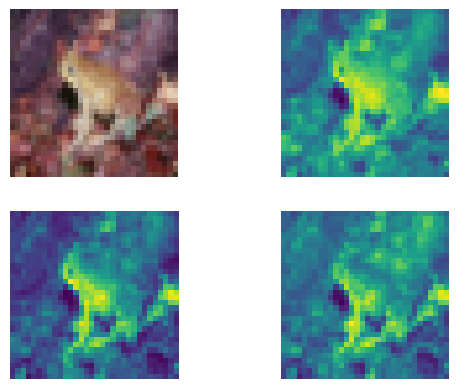

In [16]:
plt.figure()
plt.subplot(2,2,1)
plt.imshow(x_images_images[1])
plt.axis('off')


plt.subplot(2,2,2)
plt.imshow(x_images_images[1][:,:,0])
plt.axis('off')


plt.subplot(2,2,3)
plt.imshow(x_images_images[1][:,:,1])#(x_train_images[1].astype('uint8')[:,:,1])
plt.axis('off')


plt.subplot(2,2,4)
plt.imshow(x_images_images[1][:,:,2])
plt.axis('off')
print(y_onehot[1])

In [17]:
print(x_images_images.shape,y_onehot.shape)

(60000, 32, 32, 3) (60000, 10)


## 至此，我们的数据集如下：
### x_images_images----(60000, 32, 32, 3),取值范围0-1.
###        y_onehot----(60000,10)
### 为了减少模型运行时间以观察效果，我们做了两个事情，1）我们缩减了数据集，每个类别里面抽取300张图片。最终数据集为3000张图片。2）3D变2D灰度图像（可以不做）

In [18]:
## 学习list的基本操作
test_list = [[j for j in range(1)] for i in range(10)]
print(test_list)
print("----------------")
test_list[0].append(1)
print(test_list)
print("----------------")
test_list[0].pop()
print(test_list)
print("----------------")
test_list[0].pop()
print(test_list)
print("----------------")

[[0], [0], [0], [0], [0], [0], [0], [0], [0], [0]]
----------------
[[0, 1], [0], [0], [0], [0], [0], [0], [0], [0], [0]]
----------------
[[0], [0], [0], [0], [0], [0], [0], [0], [0], [0]]
----------------
[[], [0], [0], [0], [0], [0], [0], [0], [0], [0]]
----------------


In [19]:
def suojian(data,label, num):#data是需要被缩减的数据，label是对应data的标签，num是每个列别需要保留的个数
    class_label = [[j for j in range(1)] for i in range(10)]
    for i in range(10):
       # print(i)
        class_label[i].pop()#存储每个类别的索引
    for i in range(label.shape[0]):
        class_label[np.argmax(label[i])].append(i)
    #print(class_label)二维list，一维表示10个分类，一个维度记录着每个分类的图片所在下标
    #print(class_label[0][0:10])
    baoliu = []
    for i in range(10):
        temp = class_label[i][num:]
        #print(len(temp))
        baoliu.extend(temp)
    print(len(baoliu))
    #print(baoliu,len(baoliu))
    label1 =  np.delete(label,baoliu,axis=0)
    data1 = np.delete(data,baoliu,axis=0)
    x,y = sk.utils.shuffle(data1,label1,random_state=1)
    #print(data.shape,data1.shape)
    #print(label.shape,label1.shape)
    return x,y

In [20]:
suojian_x_images_images,suojian_y_onehot = suojian(x_images_images,y_onehot, 300)  #x_test_images,y_test #suojian(x_test_images,y_test, 5)
print('suojian totol images is :',suojian_x_images_images.shape)
print('suojian totol labels size is :',suojian_y_onehot.shape)

57000
suojian totol images is : (3000, 32, 32, 3)
suojian totol labels size is : (3000, 10)


### 拆分训练集/验证机/测试集，比例为8：1：1，也就是2400/300/300个。

In [21]:
# 观察过拟合现象.1)拆分数据集
def train_val_test(train_images,train_labels,ratio):
    num = train_images.shape[0] #总的数据集个数
    split_num_train = num - 2*round(num*ratio)
    split_num_val = num - round(num*ratio)
#拆分数据集和验证集
    train = train_images[:split_num_train]
    val = train_images[split_num_train:split_num_val]
    test = train_images[split_num_val:]
#拆分数据集和验证集标签
    train_label = train_labels[:split_num_train]
    val_label = train_labels[split_num_train:split_num_val]
    test_label = train_labels[split_num_val:]

    return (train,train_label,val,val_label,test,test_label)

In [22]:

(sj_train,sj_train_label,sj_val,sj_val_label,sj_test,sj_test_label) = train_val_test(suojian_x_images_images,suojian_y_onehot,0.1)
print('suojian train images is :',sj_train.shape)
print('suojian train labels size is :',sj_train_label.shape)
print('suojian val images is :',sj_val.shape)
print('suojian val labels size is :',sj_val_label.shape)
print('suojian test images is :',sj_test.shape)
print('suojian test labels size is :',sj_test_label.shape)

suojian train images is : (2400, 32, 32, 3)
suojian train labels size is : (2400, 10)
suojian val images is : (300, 32, 32, 3)
suojian val labels size is : (300, 10)
suojian test images is : (300, 32, 32, 3)
suojian test labels size is : (300, 10)


In [23]:
#### 搭建模型

In [24]:
input_shape = (32,32,3)
model = Sequential()
model.add(Conv2D(8, kernel_size=(5,5),activation='sigmoid',padding='same', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2,2), strides=2))
model.add(Conv2D(16,kernel_size=(5,5),activation='sigmoid',padding='same'))
model.add(MaxPooling2D(pool_size=(2,2), strides=2))
model.add(Flatten())
model.add(Dense(units=10,activation='sigmoid'))
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 8)           │             608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 16)          │           3,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 10)                  │          10,250 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,074 (54.98 KB)

 Trainable params: 14,074 (54.98 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
model.compile(loss = 'mse', optimizer = optimizers.SGD(),metrics = ['accuracy'])

In [26]:
print(sj_train.shape,sj_train_label.shape)

(2400, 32, 32, 3) (2400, 10)


In [27]:
model.fit(sj_train,sj_train_label,batch_size=4,epochs=10,verbose=1)

Epoch 1/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.0888 - loss: 0.1061
Epoch 2/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.0975 - loss: 0.0901
Epoch 3/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.1074 - loss: 0.0900
Epoch 4/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1000 - loss: 0.0901
Epoch 5/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1149 - loss: 0.0900
Epoch 6/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.1016 - loss: 0.0900
Epoch 7/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0972 - loss: 0.0900
Epoch 8/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0851 - loss: 0.0901
Epoch 9/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.1114 - loss: 0.0900
Epoch 10/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1022 - loss: 0.0901


In [28]:
model.evaluate(sj_test,sj_test_label) #其实该函数第一个返回值是损失（loss)，第二个返回值是准确率(acc)

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.1024 - loss: 0.0901


[0.09016094356775284, 0.10000000149011612]

### 模型性能提升：1）优化器。2）激活函数。3）损失函数.4）过拟合。5）数据增强。

####  1)优化器 Adam虽然可以自动调整学习率，可是初始学习率过大，很可能直接收敛到很差的局部最小值点，而后面的学习因为学习率已经被降低，就再也跳不出去了。所以不宜过大。一般的框架中，默认学习率1e-3。

In [29]:
#优化器,参考链接https://zhuanlan.zhihu.com/p/378629475优化器不同,收敛速度和效果会有不同,具体模型表现不一样,是一个尝试调参的过程.
model2 = Sequential()
model2.add(Conv2D(8, kernel_size=(5,5),activation='sigmoid',padding='same', input_shape=input_shape))
model2.add(MaxPooling2D(pool_size=(2,2), strides=2))
model2.add(Conv2D(16,kernel_size=(5,5),activation='sigmoid',padding='same'))
model2.add(MaxPooling2D(pool_size=(2,2), strides=2))
model2.add(Flatten())
model2.add(Dense(units=10,activation='sigmoid'))
model2.summary()
#优化器改为ADAM
model2.compile(loss = 'mse', optimizer = optimizers.Adam(0.001),metrics = ['accuracy'])
model2.fit(sj_train,sj_train_label,batch_size=4,epochs=10,verbose=2)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 8)           │             608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 16, 16)          │           3,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 8, 8, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │          10,250 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,074 (54.98 KB)

 Trainable params: 14,074 (54.98 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
600/600 - 4s - 7ms/step - accuracy: 0.1063 - loss: 0.0914
Epoch 2/10
600/600 - 4s - 6ms/step - accuracy: 0.2104 - loss: 0.0868
Epoch 3/10
600/600 - 1s - 2ms/step - accuracy: 0.2654 - loss: 0.0841
Epoch 4/10
600/600 - 3s - 4ms/step - accuracy: 0.2725 - loss: 0.0834
Epoch 5/10
600/600 - 1s - 2ms/step - accuracy: 0.2962 - loss: 0.0825
Epoch 6/10
600/600 - 1s - 2ms/step - accuracy: 0.3021 - loss: 0.0818
Epoch 7/10
600/600 - 2s - 3ms/step - accuracy: 0.3296 - loss: 0.0801
Epoch 8/10
600/600 - 2s - 4ms/step - accuracy: 0.3483 - loss: 0.0784
Epoch 9/10
600/600 - 2s - 4ms/step - accuracy: 0.3800 - loss: 0.0767
Epoch 10/10
600/600 - 2s - 4ms/step - accuracy: 0.3858 - loss: 0.0752


In [30]:
model2.evaluate(sj_test,sj_test_label) #其实该函数第一个返回值是损失（loss)，第二个返回值是准确率(acc)

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.4222 - loss: 0.0753


[0.07640385627746582, 0.4033333361148834]

#### 2)激活函数 之sigmoid--softmax

In [31]:
#sigmoid ---- softmax
model3 = Sequential()
model3.add(Conv2D(8, kernel_size=(5,5),activation='softmax',padding='same', input_shape=input_shape))
model3.add(MaxPooling2D(pool_size=(2,2), strides=2))
model3.add(Conv2D(16,kernel_size=(5,5),activation='softmax',padding='same'))
model3.add(MaxPooling2D(pool_size=(2,2), strides=2))
model3.add(Flatten())
model3.add(Dense(units=10,activation='softmax'))
model3.summary()
#优化器改为ADAM
model3.compile(loss = 'mse', optimizer = optimizers.Adam(),metrics = ['accuracy'])
model3.fit(sj_train,sj_train_label,batch_size=4,epochs=10,verbose=2)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 32, 32, 8)           │             608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 16, 16, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 16, 16, 16)          │           3,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 8, 8, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │          10,250 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,074 (54.98 KB)

 Trainable params: 14,074 (54.98 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
600/600 - 3s - 5ms/step - accuracy: 0.1358 - loss: 0.0891
Epoch 2/10
600/600 - 2s - 3ms/step - accuracy: 0.2604 - loss: 0.0841
Epoch 3/10
600/600 - 2s - 3ms/step - accuracy: 0.2754 - loss: 0.0832
Epoch 4/10
600/600 - 3s - 4ms/step - accuracy: 0.3038 - loss: 0.0816
Epoch 5/10
600/600 - 1s - 2ms/step - accuracy: 0.3354 - loss: 0.0794
Epoch 6/10
600/600 - 3s - 4ms/step - accuracy: 0.3496 - loss: 0.0777
Epoch 7/10
600/600 - 1s - 2ms/step - accuracy: 0.3717 - loss: 0.0760
Epoch 8/10
600/600 - 2s - 3ms/step - accuracy: 0.3871 - loss: 0.0744
Epoch 9/10
600/600 - 3s - 4ms/step - accuracy: 0.3975 - loss: 0.0731
Epoch 10/10
600/600 - 2s - 4ms/step - accuracy: 0.4217 - loss: 0.0719


In [32]:
model3.evaluate(sj_test,sj_test_label) #其实该函数第一个返回值是损失（loss)，第二个返回值是准确率(acc)

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.3666 - loss: 0.0765


[0.0757206380367279, 0.3733333349227905]

In [33]:
##softmax 函数返回值测试验证代码。可省略
#xp = model3.predict(suojian_x_test_images_2d)
#j=0
#for i in range(len(suojian_x_test_images_2d)):
    #tem = np.argmax(xp[i])
    #print(tem)
    #if (tem == np.argmax(suojian_y_test[i])):
       # j = j+1
#print(j/len(suojian_x_test_images_2d))

### 2)激活函数之 relu,该函数解决部分梯度弥散问题,收敛速度更快

In [34]:
#激活函数,relu使用,解决部分梯度弥散问题,收敛速度更快
model4 = Sequential()
model4.add(Conv2D(8, kernel_size=(5,5),activation='relu',padding='same', input_shape=input_shape))
model4.add(MaxPooling2D(pool_size=(2,2), strides=2))
model4.add(Conv2D(16,kernel_size=(5,5),activation='relu',padding='same'))
model4.add(MaxPooling2D(pool_size=(2,2), strides=2))
model4.add(Flatten())
model4.add(Dense(units=10,activation='softmax'))
model4.summary()
#优化器改为ADAM
model4.compile(loss = 'mse', optimizer = optimizers.Adam(),metrics = ['accuracy'])
model4.fit(sj_train,sj_train_label,batch_size=4,epochs=10,verbose=2)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 32, 32, 8)           │             608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 16, 16, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 16, 16, 16)          │           3,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 8, 8, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │          10,250 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,074 (54.98 KB)

 Trainable params: 14,074 (54.98 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
600/600 - 3s - 5ms/step - accuracy: 0.2425 - loss: 0.0851
Epoch 2/10
600/600 - 1s - 2ms/step - accuracy: 0.3525 - loss: 0.0781
Epoch 3/10
600/600 - 1s - 2ms/step - accuracy: 0.4242 - loss: 0.0724
Epoch 4/10
600/600 - 3s - 5ms/step - accuracy: 0.4658 - loss: 0.0671
Epoch 5/10
600/600 - 1s - 2ms/step - accuracy: 0.5213 - loss: 0.0616
Epoch 6/10
600/600 - 1s - 2ms/step - accuracy: 0.5683 - loss: 0.0563
Epoch 7/10
600/600 - 1s - 2ms/step - accuracy: 0.6225 - loss: 0.0513
Epoch 8/10
600/600 - 1s - 2ms/step - accuracy: 0.6600 - loss: 0.0476
Epoch 9/10
600/600 - 1s - 2ms/step - accuracy: 0.6925 - loss: 0.0433
Epoch 10/10
600/600 - 1s - 2ms/step - accuracy: 0.7262 - loss: 0.0399


In [35]:
model4.evaluate(sj_test,sj_test_label) #其实该函数第一个返回值是损失（loss)，第二个返回值是准确率(acc)

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.4039 - loss: 0.0807


[0.07846909761428833, 0.41999998688697815]

### 2)激活函数之 tanh,该函数解决原点对称问题

In [36]:
#激活函数,换成tanh,我们观察到底是tanh还是relu对当前情况来说,更为合适?
model5 = Sequential()
model5.add(Conv2D(8, kernel_size=(5,5),activation='relu',padding='same', input_shape=input_shape))
model5.add(MaxPooling2D(pool_size=(2,2), strides=2))
model5.add(Conv2D(16,kernel_size=(5,5),activation='relu',padding='same'))
model5.add(MaxPooling2D(pool_size=(2,2), strides=2))
model5.add(Flatten())
model5.add(Dense(units=10,activation='tanh'))
model5.summary()
#优化器改为ADAM
model5.compile(loss = 'mse', optimizer = optimizers.Adam(),metrics = ['accuracy'])
model5.fit(sj_train,sj_train_label,batch_size=4,epochs=10,verbose=2)

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 32, 32, 8)           │             608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 16, 16, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 16, 16, 16)          │           3,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 8, 8, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 10)                  │          10,250 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,074 (54.98 KB)

 Trainable params: 14,074 (54.98 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
600/600 - 3s - 5ms/step - accuracy: 0.2225 - loss: 0.0875
Epoch 2/10
600/600 - 1s - 2ms/step - accuracy: 0.3654 - loss: 0.0804
Epoch 3/10
600/600 - 3s - 4ms/step - accuracy: 0.4371 - loss: 0.0755
Epoch 4/10
600/600 - 1s - 2ms/step - accuracy: 0.5154 - loss: 0.0713
Epoch 5/10
600/600 - 3s - 4ms/step - accuracy: 0.5675 - loss: 0.0680
Epoch 6/10
600/600 - 2s - 3ms/step - accuracy: 0.6267 - loss: 0.0647
Epoch 7/10
600/600 - 2s - 3ms/step - accuracy: 0.6550 - loss: 0.0622
Epoch 8/10
600/600 - 3s - 4ms/step - accuracy: 0.6954 - loss: 0.0594
Epoch 9/10
600/600 - 1s - 2ms/step - accuracy: 0.7267 - loss: 0.0576
Epoch 10/10
600/600 - 1s - 2ms/step - accuracy: 0.7546 - loss: 0.0558


In [37]:
model5.evaluate(sj_test,sj_test_label) #其实该函数第一个返回值是损失（loss)，第二个返回值是准确率(acc)

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.3964 - loss: 0.0841


[0.08427738398313522, 0.4000000059604645]

### 总结,我们发现relu加tanh，要比relu+softmax更适合我们当前的场景.
## 请尝试一下所有激活函数是tanh的情况，会更好吗？

### 3)损失函数---交叉熵

In [38]:
#使用当前表变现优秀的relu激活函数，调整损失函数为交叉熵函数。
model6 = Sequential()
model6.add(Conv2D(8, kernel_size=(5,5),activation='relu',padding='same', input_shape=input_shape))
model6.add(MaxPooling2D(pool_size=(2,2), strides=2))
model6.add(Conv2D(16,kernel_size=(5,5),activation='relu',padding='same'))
model6.add(MaxPooling2D(pool_size=(2,2), strides=2))
model6.add(Flatten())
model6.add(Dense(units=10,activation='softmax'))
model6.summary()
#优化器改为ADAM
model6.compile(loss = 'categorical_crossentropy', optimizer = optimizers.Adam(),metrics = ['accuracy'])
model6.fit(sj_train,sj_train_label,batch_size=4,epochs=10,verbose=2)

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)                   │ (None, 32, 32, 8)           │             608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 16, 16, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 16, 16, 16)          │           3,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 8, 8, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10)                  │          10,250 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,074 (54.98 KB)

 Trainable params: 14,074 (54.98 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
600/600 - 4s - 6ms/step - accuracy: 0.2062 - loss: 2.1274
Epoch 2/10
600/600 - 2s - 3ms/step - accuracy: 0.3542 - loss: 1.8000
Epoch 3/10
600/600 - 1s - 2ms/step - accuracy: 0.4083 - loss: 1.6255
Epoch 4/10
600/600 - 1s - 2ms/step - accuracy: 0.4675 - loss: 1.4832
Epoch 5/10
600/600 - 1s - 2ms/step - accuracy: 0.5196 - loss: 1.3548
Epoch 6/10
600/600 - 3s - 4ms/step - accuracy: 0.5708 - loss: 1.2329
Epoch 7/10
600/600 - 1s - 2ms/step - accuracy: 0.6062 - loss: 1.1076
Epoch 8/10
600/600 - 2s - 3ms/step - accuracy: 0.6454 - loss: 1.0084
Epoch 9/10
600/600 - 2s - 3ms/step - accuracy: 0.6746 - loss: 0.9198
Epoch 10/10
600/600 - 2s - 3ms/step - accuracy: 0.7129 - loss: 0.8242


In [39]:
model6.evaluate(sj_test,sj_test_label) #其实该函数第一个返回值是损失（loss)，第二个返回值是准确率(acc)

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.4297 - loss: 1.8452


[1.8100242614746094, 0.4466666579246521]

### 交叉熵于mse好，relu是目前表现比较好的激活函数，另外relu+tanh+mse的方式也还不错。

### 另外我们注意到,训练结果一直上升,但是为什么模型评估函数输出的结果不仅人意呢?此时我们应该关注过拟合或者欠拟合现象.
### 过拟合或者欠拟合现象的发现需要在fit的时候设置验证集合,也就是需要把训练集的一部分(通常20%)设置为验证集.
### 过拟合的解决,有三种方法1)正则.2)dropout.3)增强数据集。欠拟合需要增加训练次数，同样可以通过解决过拟合来缓解模型的欠拟合

### 4）观察过拟合现象,利用曲线绘制epoch和train和val数据集的关系

In [40]:
#########画图,用来显示每个epoch，训练集和验证集的走向
def loss_acc_curve(history):
    print(history.history.keys())
    acc = history.history['accuracy']  #获取训练集准确性数据
    val_acc = history.history['val_accuracy'] #获取验证集准确性数据
    loss = history.history['loss']   #获取训练集错误值数据
    val_loss = history.history['val_loss'] #获取验证集错误值数据
    epochs = range(1,len(acc)+1)
    #plt.subplot(121)
    plt.plot(epochs,acc,'bo',label='Trainning acc')  #以epochs为横坐标，以训练集准确性为纵坐标
    plt.plot(epochs,val_acc,'b',label='Vaildation acc') #以epochs为横坐标，以验证集准确性为纵坐标
    plt.legend() #绘制图例，即标明图中的线段代表何种含义

   # plt.subplot(122)
    plt.figure()
    plt.plot(epochs,loss,'bo',label='Trainning loss')
    plt.plot(epochs,val_loss,'b',label='Vaildation loss')
    plt.legend() ##绘制图例，即标明图中的线段代表何种含义

In [41]:
# 添加验证集，绘制曲线，观察过拟合现象
model7 = Sequential()
model7.add(Conv2D(8, kernel_size=(5,5),activation='relu',padding='same', input_shape=input_shape))
model7.add(MaxPooling2D(pool_size=(2,2), strides=2))
model7.add(Conv2D(16,kernel_size=(5,5),activation='relu',padding='same'))
model7.add(MaxPooling2D(pool_size=(2,2), strides=2))
model7.add(Flatten())
model7.add(Dense(units=10,activation='softmax'))
model7.summary()
#优化器改为ADAM
model7.compile(loss = 'categorical_crossentropy', optimizer = optimizers.Adam(),metrics = ['accuracy'])
history7 = model7.fit(sj_train,sj_train_label,validation_data=(sj_val,sj_val_label),batch_size=4,epochs=20,verbose=1)
#model.fit 中的 verbose
#verbose：日志显示
#verbose = 0 为不在标准输出流输出日志信息
#verbose = 1 为输出进度条记录
#verbose = 2 为每个epoch输出一行记录
#注意： 默认为 1

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (None, 32, 32, 8)           │             608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 16, 16, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 16, 16, 16)          │           3,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 8, 8, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 10)                  │          10,250 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,074 (54.98 KB)

 Trainable params: 14,074 (54.98 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.1532 - loss: 2.2471 - val_accuracy: 0.3367 - val_loss: 1.8523
Epoch 2/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.3587 - loss: 1.7975 - val_accuracy: 0.4233 - val_loss: 1.7113
Epoch 3/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4549 - loss: 1.5614 - val_accuracy: 0.3800 - val_loss: 1.6802
Epoch 4/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4988 - loss: 1.4028 - val_accuracy: 0.4200 - val_loss: 1.6192
Epoch 5/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5548 - loss: 1.2627 - val_accuracy: 0.4433 - val_loss: 1.6020
Epoch 6/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6088 - loss: 1.1132 - val_accuracy: 0.4267 - val_loss: 1.6563
Epoch 7/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6625 - loss: 1.0018 - val_accuracy: 0.4267 - val_loss: 1.6848
Epoch 8/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6874 - loss: 0.8697 - val_accuracy: 0.

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


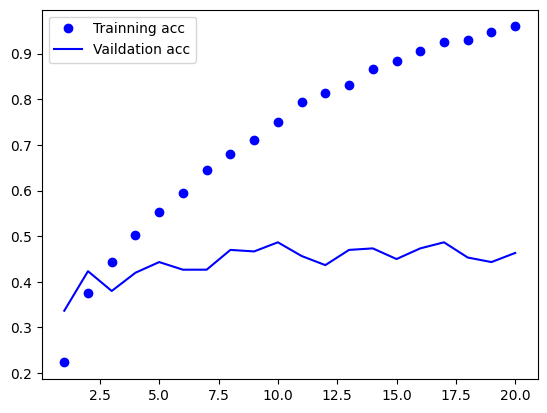

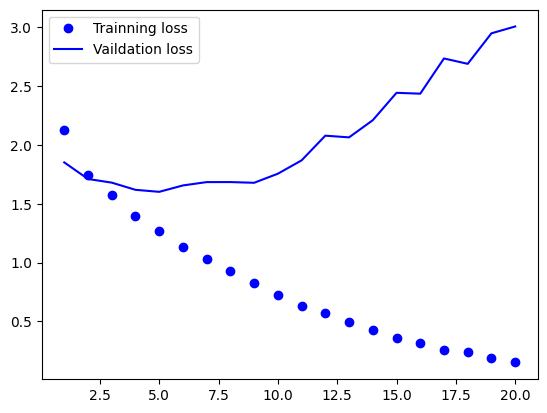

In [42]:
loss_acc_curve(history7)

In [43]:
model7.evaluate(sj_test,sj_test_label) #其实该函数第一个返回值是损失（loss)，第二个返回值是准确率(acc)

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.3808 - loss: 3.3824


[3.3811182975769043, 0.4099999964237213]

## 总结：大概第8次左右出现过拟合现象

### 在图上我们看到验证集loss曲线在第7次的时候立马上升，我们发现模型对于数据集来说存在严重的过拟合现象。
### 过拟合的解决,有三种方法1)正则.2)dropout.3)增强数据集.4)简单化模型结构

In [44]:
# 添加dropout
model8 = Sequential()
model8.add(Conv2D(8, kernel_size=(5,5),activation='relu',padding='same', input_shape=input_shape))
model8.add(MaxPooling2D(pool_size=(2,2), strides=2))
#model8.add(Dropout(0.2))
model8.add(Conv2D(16,kernel_size=(5,5),activation='relu',padding='same'))
model8.add(MaxPooling2D(pool_size=(2,2), strides=2))
model8.add(Dropout(0.2))
model8.add(Flatten())
model8.add(Dense(units=10,activation='softmax'))
model8.summary()
#优化器改为ADAM
model8.compile(loss = 'categorical_crossentropy', optimizer = optimizers.Adam(),metrics = ['accuracy'])
history8 = model8.fit(sj_train,sj_train_label,validation_data=(sj_val,sj_val_label),batch_size=4,epochs=20,verbose=1)

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)                   │ (None, 32, 32, 8)           │             608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 16, 16, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 16, 16, 16)          │           3,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 8, 8, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 8, 8, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 10)                  │          10,250 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,074 (54.98 KB)

 Trainable params: 14,074 (54.98 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.1639 - loss: 2.2248 - val_accuracy: 0.3067 - val_loss: 1.9331
Epoch 2/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.3281 - loss: 1.8889 - val_accuracy: 0.2867 - val_loss: 1.9731
Epoch 3/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.3840 - loss: 1.7175 - val_accuracy: 0.4167 - val_loss: 1.6717
Epoch 4/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4471 - loss: 1.5756 - val_accuracy: 0.4000 - val_loss: 1.6767
Epoch 5/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4637 - loss: 1.4697 - val_accuracy: 0.4700 - val_loss: 1.5497
Epoch 6/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5179 - loss: 1.3906 - val_accuracy: 0.4267 - val_loss: 1.6303
Epoch 7/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5520 - loss: 1.3082 - val_accuracy: 0.4500 - val_loss: 1.6369
Epoch 8/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5644 - loss: 1.2401 - val_accuracy: 0.

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.4306 - loss: 2.0433


[2.0240447521209717, 0.4566666781902313]

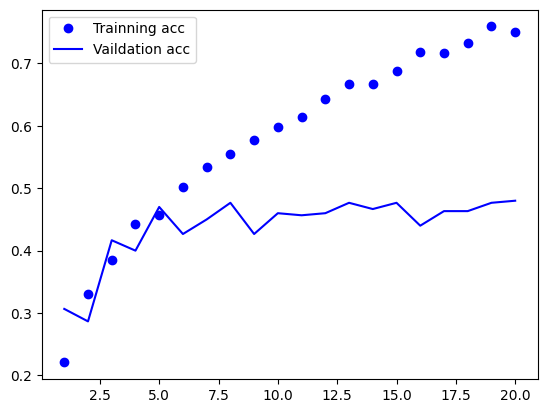

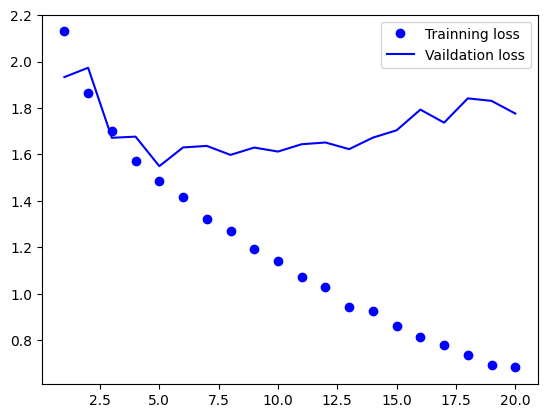

In [45]:
loss_acc_curve(history8)
model8.evaluate(sj_test,sj_test_label) #其实该函数第一个返回值是损失（loss)，第二个返回值是准确率(acc)

### 总结：添加Dropout以后，模型的过拟合现象有所减轻，验证loss大概在12次左右产生

In [46]:
# 添加正则,还可以使用tf.keras.regularizers.L1()来查看模型的效果
model9 = Sequential()
model9.add(Conv2D(8, kernel_size=(5,5),activation='relu',padding='same', input_shape=input_shape))
model9.add(MaxPooling2D(pool_size=(2,2), strides=2))
#model9.add(Dropout(0.2))
model9.add(Conv2D(16,kernel_size=(5,5),activation='relu',kernel_regularizer = tf.keras.regularizers.L2(),padding='same'))
model9.add(MaxPooling2D(pool_size=(2,2), strides=2))
#model8.add(Dropout(0.2))
model9.add(Flatten())
model9.add(Dense(units=10,activation='softmax'))
model9.summary()
#优化器改为ADAM
model9.compile(loss = 'categorical_crossentropy', optimizer = optimizers.Adam(),metrics = ['accuracy'])  #categorical_crossentropy
history9 = model9.fit(sj_train,sj_train_label,validation_data=(sj_val,sj_val_label),batch_size=4,epochs=15,verbose=1)

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)                   │ (None, 32, 32, 8)           │             608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 16, 16, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 16, 16, 16)          │           3,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 8, 8, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_8 (Flatten)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 10)                  │          10,250 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,074 (54.98 KB)

 Trainable params: 14,074 (54.98 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.1429 - loss: 2.2972 - val_accuracy: 0.3367 - val_loss: 1.8863
Epoch 2/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.3543 - loss: 1.8555 - val_accuracy: 0.3367 - val_loss: 1.9236
Epoch 3/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.4212 - loss: 1.6952 - val_accuracy: 0.4167 - val_loss: 1.7024
Epoch 4/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4686 - loss: 1.5610 - val_accuracy: 0.4433 - val_loss: 1.6200
Epoch 5/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4725 - loss: 1.5125 - val_accuracy: 0.4267 - val_loss: 1.6753
Epoch 6/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5224 - loss: 1.4003 - val_accuracy: 0.4367 - val_loss: 1.6142
Epoch 7/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5697 - loss: 1.3193 - val_accuracy: 0.4433 - val_loss: 1.6747
Epoch 8/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5631 - loss: 1.2776 - val_accuracy: 0.

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.4778 - loss: 1.8363


[1.8177958726882935, 0.47333332896232605]

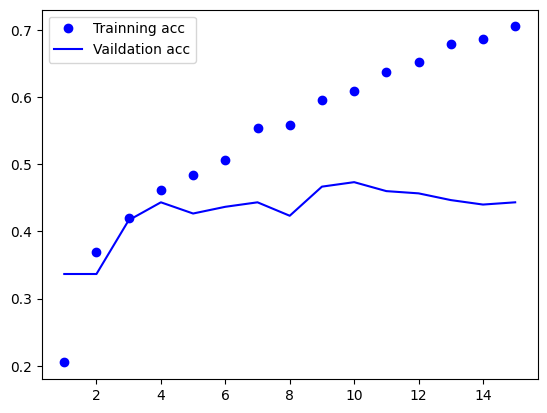

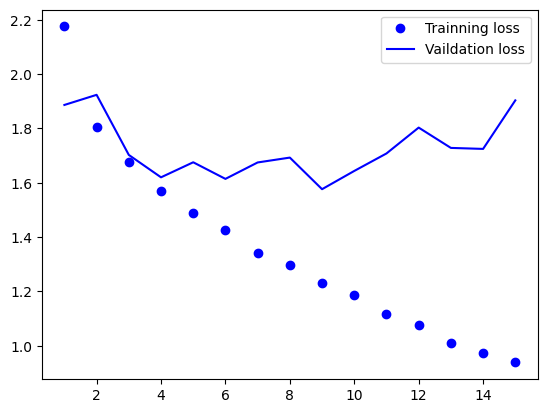

In [47]:
loss_acc_curve(history9)
model9.evaluate(sj_test,sj_test_label) #其实该函数第一个返回值是损失（loss)，第二个返回值是准确率(acc)

In [48]:
# 添加正则,还可以使用tf.keras.regularizers.L1()来查看模型的效果
model9_1 = Sequential()
model9_1.add(Conv2D(8, kernel_size=(5,5),activation='relu',padding='same', input_shape=input_shape))
model9_1.add(MaxPooling2D(pool_size=(2,2), strides=2))
#model9.add(Dropout(0.2))
model9_1.add(Conv2D(16,kernel_size=(5,5),activation='relu',kernel_regularizer = tf.keras.regularizers.L1(),padding='same'))
model9_1.add(MaxPooling2D(pool_size=(2,2), strides=2))
#model8.add(Dropout(0.2))
model9_1.add(Flatten())
model9_1.add(Dense(units=10,activation='softmax'))
model9_1.summary()
#优化器改为ADAM
model9_1.compile(loss = 'categorical_crossentropy', optimizer = optimizers.Adam(),metrics = ['accuracy'])
history9_1 = model9_1.fit(sj_train,sj_train_label,validation_data=(sj_val,sj_val_label),batch_size=4,epochs=20,verbose=1)

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)                   │ (None, 32, 32, 8)           │             608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 16, 16, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 16, 16, 16)          │           3,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 8, 8, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_9 (Flatten)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 10)                  │          10,250 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,074 (54.98 KB)

 Trainable params: 14,074 (54.98 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.1462 - loss: 2.8040 - val_accuracy: 0.2333 - val_loss: 2.2776
Epoch 2/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.2471 - loss: 2.1031 - val_accuracy: 0.2100 - val_loss: 2.1949
Epoch 3/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2912 - loss: 2.0266 - val_accuracy: 0.2500 - val_loss: 2.1116
Epoch 4/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.3110 - loss: 1.9848 - val_accuracy: 0.3067 - val_loss: 2.0182
Epoch 5/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3312 - loss: 1.9783 - val_accuracy: 0.3333 - val_loss: 1.9565
Epoch 6/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.3473 - loss: 1.8935 - val_accuracy: 0.3400 - val_loss: 1.8803
Epoch 7/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3661 - loss: 1.7998 - val_accuracy: 0.3633 - val_loss: 1.8346
Epoch 8/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3893 - loss: 1.7623 - val_accuracy: 0.

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.3522 - loss: 1.8987


[1.8154890537261963, 0.3766666650772095]

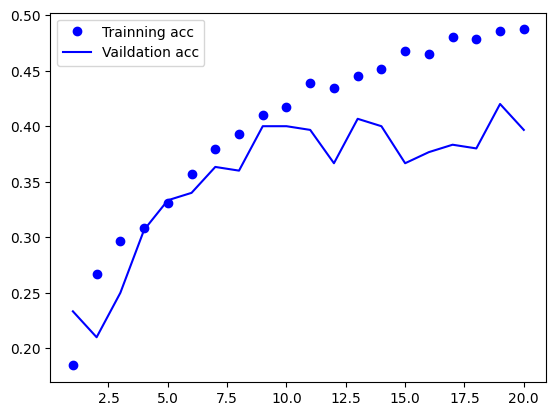

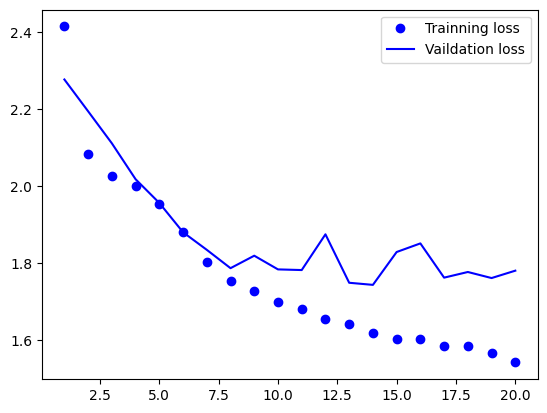

In [49]:
loss_acc_curve(history9_1)
model9_1.evaluate(sj_test,sj_test_label) #其实该函数第一个返回值是损失（loss)，第二个返回值是准确率(acc)

### L2正则，过拟合在10次左右。使用L1正则，大概在20次左右，下面我们来验证下，联合使用正则和Dropout的效果

In [50]:
# 添加正则和dropout
model10 = Sequential()
model10.add(Conv2D(8, kernel_size=(5,5),activation='relu',kernel_regularizer = tf.keras.regularizers.L1(),padding='same', input_shape=input_shape))
model10.add(MaxPooling2D(pool_size=(2,2), strides=2))
#model9.add(Dropout(0.2))
model10.add(Conv2D(16,kernel_size=(5,5),activation='relu',padding='same'))
model10.add(MaxPooling2D(pool_size=(2,2), strides=2))
model10.add(Dropout(0.2))
model10.add(Flatten())
model10.add(Dense(units=10,activation='softmax'))
model10.summary()
#优化器改为ADAM
model10.compile(loss = 'categorical_crossentropy', optimizer = optimizers.Adam(),metrics = ['accuracy'])
history10 = model10.fit(sj_train,sj_train_label,validation_data=(sj_val,sj_val_label),batch_size=4,epochs=40,verbose=1)

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)                   │ (None, 32, 32, 8)           │             608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_20 (MaxPooling2D)      │ (None, 16, 16, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 16, 16, 16)          │           3,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_21 (MaxPooling2D)      │ (None, 8, 8, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 8, 8, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_10 (Flatten)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 10)                  │          10,250 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,074 (54.98 KB)

 Trainable params: 14,074 (54.98 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
600/600 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.1558 - loss: 2.5014 - val_accuracy: 0.3033 - val_loss: 2.0743
Epoch 2/40
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.2889 - loss: 2.0547 - val_accuracy: 0.3200 - val_loss: 1.8800
Epoch 3/40
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3484 - loss: 1.8780 - val_accuracy: 0.3933 - val_loss: 1.7923
Epoch 4/40
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4234 - loss: 1.7073 - val_accuracy: 0.4000 - val_loss: 1.7729
Epoch 5/40
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4517 - loss: 1.6404 - val_accuracy: 0.4167 - val_loss: 1.7090
Epoch 6/40
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4694 - loss: 1.5964 - val_accuracy: 0.4267 - val_loss: 1.7427
Epoch 7/40
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4782 - loss: 1.5228 - val_accuracy: 0.4400 - val_loss: 1.7272
Epoch 8/40
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5053 - loss: 1.4736 - val_accuracy: 0.

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.4531 - loss: 2.0907


[2.0798046588897705, 0.476666659116745]

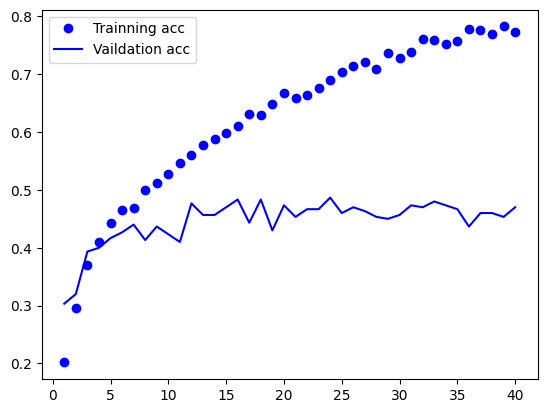

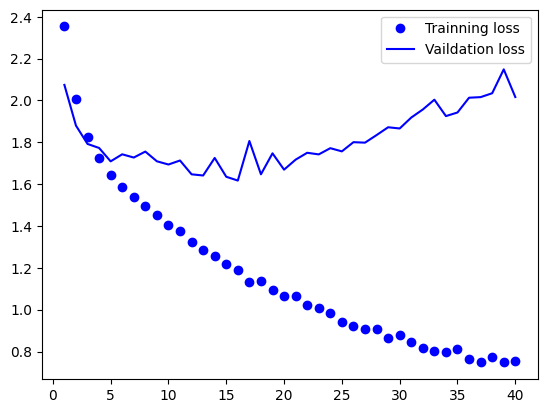

In [51]:
loss_acc_curve(history10)
model10.evaluate(sj_test,sj_test_label) #其实该函数第一个返回值是损失（loss)，第二个返回值是准确率(acc)

In [52]:
# 添加正则和dropout
model11 = Sequential()
model11.add(Conv2D(8, kernel_size=(5,5),activation='relu',padding='same', input_shape=input_shape))
model11.add(MaxPooling2D(pool_size=(2,2), strides=2))
model11.add(Dropout(0.2))
model11.add(Conv2D(16,kernel_size=(5,5),activation='relu',kernel_regularizer = tf.keras.regularizers.L1(),padding='same'))
model11.add(MaxPooling2D(pool_size=(2,2), strides=2))
model11.add(Dropout(0.2))
model11.add(Flatten())
model11.add(Dense(units=10,activation='softmax'))
model11.summary()
#优化器改为ADAM
model11.compile(loss = 'categorical_crossentropy', optimizer = optimizers.Adam(),metrics = ['accuracy'])
history11 = model11.fit(sj_train,sj_train_label,validation_data=(sj_val,sj_val_label),batch_size=4,epochs=40,verbose=1)

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_22 (Conv2D)                   │ (None, 32, 32, 8)           │             608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_22 (MaxPooling2D)      │ (None, 16, 16, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 16, 16, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 16, 16, 16)          │           3,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_23 (MaxPooling2D)      │ (None, 8, 8, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 8, 8, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_11 (Flatten)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 10)                  │          10,250 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,074 (54.98 KB)

 Trainable params: 14,074 (54.98 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
600/600 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.1227 - loss: 2.9556 - val_accuracy: 0.2233 - val_loss: 2.1568
Epoch 2/40
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2154 - loss: 2.1520 - val_accuracy: 0.2600 - val_loss: 2.0661
Epoch 3/40
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.2682 - loss: 2.0494 - val_accuracy: 0.2667 - val_loss: 2.0523
Epoch 4/40
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2733 - loss: 2.0084 - val_accuracy: 0.2867 - val_loss: 2.0553
Epoch 5/40
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.2955 - loss: 2.0129 - val_accuracy: 0.2400 - val_loss: 2.0274
Epoch 6/40
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2760 - loss: 2.0104 - val_accuracy: 0.2633 - val_loss: 2.0712
Epoch 7/40
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3222 - loss: 1.9706 - val_accuracy: 0.2467 - val_loss: 2.0643
Epoch 8/40
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2953 - loss: 1.9944 - val_accuracy: 0.

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.3505 - loss: 1.8729


[1.8241387605667114, 0.3733333349227905]

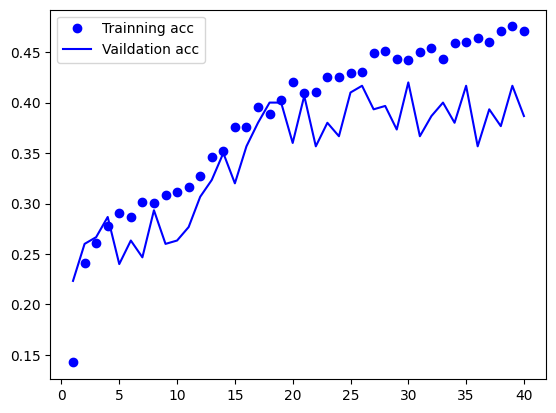

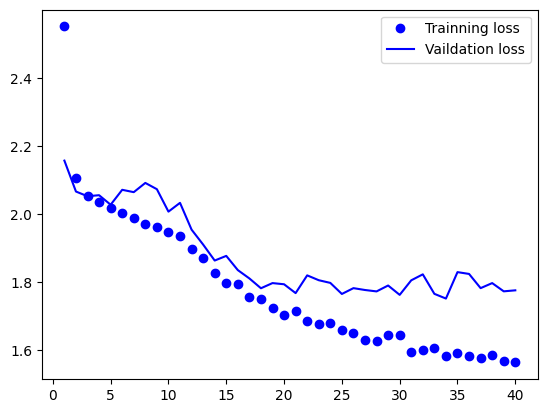

In [53]:
loss_acc_curve(history11)
model11.evaluate(sj_test,sj_test_label) #其实该函数第一个返回值是损失（loss)，第二个返回值是准确率(acc)

### 太多的降低参数个数，模型过拟合会降低，但是对应的是模型准确率的震荡和下降

In [54]:
#两个Dropout函数
model12 = Sequential()
model12.add(Conv2D(8, kernel_size=(5,5),activation='relu',padding='same', input_shape=input_shape))
model12.add(MaxPooling2D(pool_size=(2,2), strides=2))
model12.add(Dropout(0.2))
model12.add(Conv2D(16,kernel_size=(5,5),activation='relu',padding='same'))
model12.add(MaxPooling2D(pool_size=(2,2), strides=2))
model12.add(Dropout(0.2))
model12.add(Flatten())
model12.add(Dense(units=10,activation='softmax'))
model12.summary()
#优化器改为ADAM
model12.compile(loss = 'categorical_crossentropy', optimizer = optimizers.Adam(),metrics = ['accuracy'])
history12 = model12.fit(sj_train,sj_train_label,validation_data=(sj_val,sj_val_label),batch_size=4,epochs=35,verbose=1)

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)                   │ (None, 32, 32, 8)           │             608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_24 (MaxPooling2D)      │ (None, 16, 16, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 16, 16, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 16, 16, 16)          │           3,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_25 (MaxPooling2D)      │ (None, 8, 8, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 8, 8, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_12 (Flatten)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 10)                  │          10,250 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,074 (54.98 KB)

 Trainable params: 14,074 (54.98 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/35
600/600 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.1526 - loss: 2.2410 - val_accuracy: 0.2633 - val_loss: 1.9857
Epoch 2/35
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2865 - loss: 1.9727 - val_accuracy: 0.3467 - val_loss: 1.8332
Epoch 3/35
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3704 - loss: 1.7847 - val_accuracy: 0.3500 - val_loss: 1.7806
Epoch 4/35
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4147 - loss: 1.6297 - val_accuracy: 0.4267 - val_loss: 1.6319
Epoch 5/35
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4783 - loss: 1.5116 - val_accuracy: 0.4300 - val_loss: 1.5837
Epoch 6/35
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4867 - loss: 1.4708 - val_accuracy: 0.4133 - val_loss: 1.6275
Epoch 7/35
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5116 - loss: 1.3764 - val_accuracy: 0.4433 - val_loss: 1.5610
Epoch 8/35
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5243 - loss: 1.3396 - val_accuracy: 0.

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.4206 - loss: 1.9903


[1.881188988685608, 0.4466666579246521]

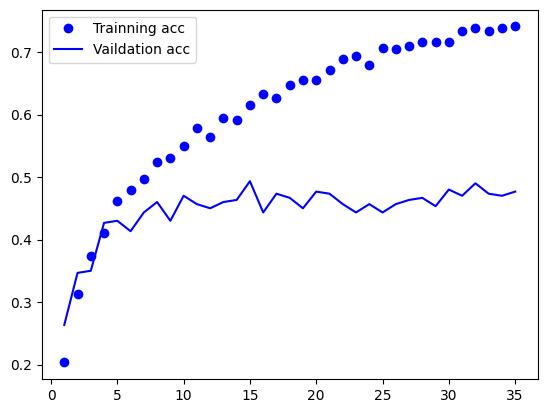

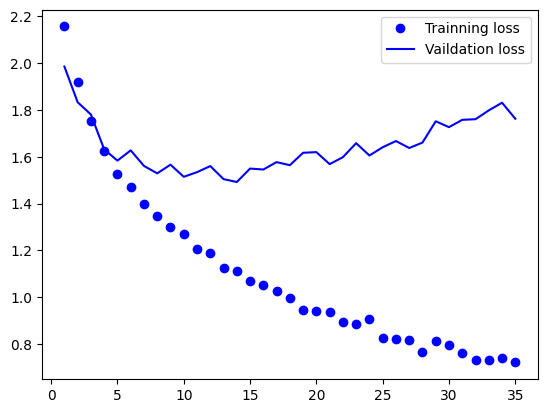

In [55]:
loss_acc_curve(history12)
model12.evaluate(sj_test,sj_test_label) #其实该函数第一个返回值是损失（loss)，第二个返回值是准确率(acc)

### 总结：第一个卷积添加L1正则，在之后添加dropout，是当前环境下，准确率和抑制过拟合比较合适的选择。
### 扩增数据集能减轻过拟合现象,表现为验证集和训练集的曲线更为接近，我们利用缩减函数得到我们想要的3000个数据集，然后利用分割函数分为训练/测试/验证三个集合
### suojian_x_images_images,suojian_y_onehot = suojian(x_images_images,y_onehot, 300)  #x_test_images,y_test ####
### suojian(x_test_images,y_test, 5)
### print('suojian totol images is :',suojian_x_images_images.shape)
### print('suojian totol labels size is :',suojian_y_onehot.shape)

In [56]:
suojian_x_images_images_v2,suojian_y_onehot_v2 = suojian(x_images_images,y_onehot, 600)  #x_test_images,y_test #suojian(x_test_images,y_test, 5)
print('suojian totol images is :',suojian_x_images_images_v2.shape)
print('suojian totol labels size is :',suojian_y_onehot_v2.shape)

54000
suojian totol images is : (6000, 32, 32, 3)
suojian totol labels size is : (6000, 10)


In [57]:
(sj_train_2,sj_train_label_2,sj_val_2,sj_val_label_2,sj_test_2,sj_test_label_2) = train_val_test(suojian_x_images_images_v2,suojian_y_onehot_v2,0.1)
print('suojian train images is :',sj_train_2.shape)
print('suojian train labels size is :',sj_train_label_2.shape)
print('suojian val images is :',sj_val_2.shape)
print('suojian val labels size is :',sj_val_label_2.shape)
print('suojian test images is :',sj_test_2.shape)
print('suojian test labels size is :',sj_test_label_2.shape)

suojian train images is : (4800, 32, 32, 3)
suojian train labels size is : (4800, 10)
suojian val images is : (600, 32, 32, 3)
suojian val labels size is : (600, 10)
suojian test images is : (600, 32, 32, 3)
suojian test labels size is : (600, 10)


In [58]:
model13 = Sequential()
model13.add(Conv2D(8, kernel_size=(5,5),activation='relu',kernel_regularizer = tf.keras.regularizers.L1(),padding='same', input_shape=input_shape))
model13.add(MaxPooling2D(pool_size=(2,2), strides=2))
#model13.add(Dropout(0.2))
model13.add(Conv2D(16,kernel_size=(5,5),activation='relu',padding='same'))
model13.add(MaxPooling2D(pool_size=(2,2), strides=2))
model13.add(Dropout(0.2))
model13.add(Flatten())
model13.add(Dense(units=10,activation='softmax'))
model13.summary()
#优化器改为ADAM
model13.compile(loss = 'categorical_crossentropy', optimizer = optimizers.Adam(),metrics = ['accuracy'])
history13 = model13.fit(sj_train_2,sj_train_label_2,validation_data=(sj_val_2,sj_val_label_2),batch_size=4,epochs=40,verbose=1)

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_26 (Conv2D)                   │ (None, 32, 32, 8)           │             608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_26 (MaxPooling2D)      │ (None, 16, 16, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_27 (Conv2D)                   │ (None, 16, 16, 16)          │           3,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_27 (MaxPooling2D)      │ (None, 8, 8, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 8, 8, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_13 (Flatten)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 10)                  │          10,250 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,074 (54.98 KB)

 Trainable params: 14,074 (54.98 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.1815 - loss: 2.4122 - val_accuracy: 0.3967 - val_loss: 1.8645
Epoch 2/40
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.3639 - loss: 1.8747 - val_accuracy: 0.4183 - val_loss: 1.7336
Epoch 3/40
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.4238 - loss: 1.6861 - val_accuracy: 0.4483 - val_loss: 1.6682
Epoch 4/40
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.4700 - loss: 1.6009 - val_accuracy: 0.4283 - val_loss: 1.7142
Epoch 5/40
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.4797 - loss: 1.5424 - val_accuracy: 0.4417 - val_loss: 1.6546
Epoch 6/40
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.4979 - loss: 1.4992 - val_accuracy: 0.4883 - val_loss: 1.6021
Epoch 7/40
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5231 - loss: 1.4267 - val_accuracy: 0.4583 - val_loss: 1.5633
Epoch 8/40
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5390 - loss: 1.3652 - 

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.5118 - loss: 1.6524


[1.7427465915679932, 0.5049999952316284]

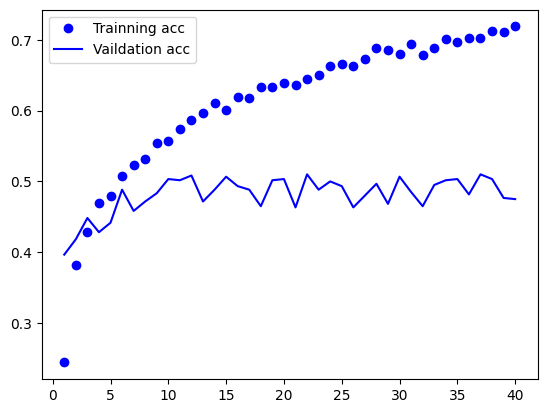

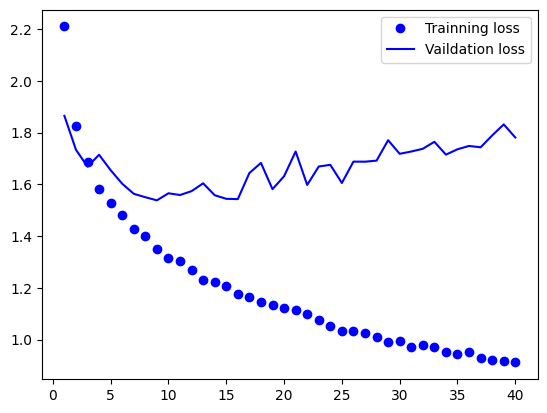

In [59]:
loss_acc_curve(history13)
model13.evaluate(sj_test_2,sj_test_label_2) #其实该函数第一个返回值是损失（loss)，第二个返回值是准确率(acc)

### 总结，1）增加数据集，可以把在模型优化基础上,减轻过拟合现象，让模型准确率有轻微的提升。
###   2）同时我们应该意识到，我们epoch=40并不是模型最佳点，也就是说训练到40次的时候，模型性能并不太好，看上图，也许在epoch=15左右的时候也许最佳。

### 4)简单化模型,过拟合现象可以降低

In [60]:
#减少卷积核个数,缩小卷积核尺寸,减少模型复杂度,可以缓解过拟合现象,提高准确率
#卷积核个数是提取特征,因此缩小尺寸比直接减少卷积核个数要更为合适一些,但是也需要实验才能根据自己的数据情况来决定
model14 = Sequential()
model14.add(Conv2D(8, kernel_size=(3,3),activation='relu',kernel_regularizer = tf.keras.regularizers.L1(),padding='same', input_shape=input_shape))
model14.add(MaxPooling2D(pool_size=(2,2), strides=2))
#model14.add(Dropout(0.2))
model14.add(Conv2D(16,kernel_size=(3,3),activation='relu',padding='same'))
model14.add(MaxPooling2D(pool_size=(2,2), strides=2))
model13.add(Dropout(0.2))
model14.add(Flatten())
model14.add(Dense(units=10,activation='softmax'))
model14.summary()
#优化器改为ADAM
model14.compile(loss = 'categorical_crossentropy', optimizer = optimizers.Adam(),metrics = ['accuracy'])
history14 = model14.fit(sj_train_2,sj_train_label_2,validation_data=(sj_val_2,sj_val_label_2),batch_size=4,epochs=20,verbose=1)

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_28 (Conv2D)                   │ (None, 32, 32, 8)           │             224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_28 (MaxPooling2D)      │ (None, 16, 16, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_29 (Conv2D)                   │ (None, 16, 16, 16)          │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_29 (MaxPooling2D)      │ (None, 8, 8, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_14 (Flatten)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 10)                  │          10,250 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,642 (45.48 KB)

 Trainable params: 11,642 (45.48 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.1897 - loss: 2.3123 - val_accuracy: 0.3583 - val_loss: 1.8546
Epoch 2/20
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.4023 - loss: 1.8037 - val_accuracy: 0.4317 - val_loss: 1.7064
Epoch 3/20
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.4615 - loss: 1.6399 - val_accuracy: 0.4333 - val_loss: 1.6735
Epoch 4/20
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.4926 - loss: 1.5202 - val_accuracy: 0.4600 - val_loss: 1.5896
Epoch 5/20
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.5151 - loss: 1.4613 - val_accuracy: 0.4867 - val_loss: 1.5575
Epoch 6/20
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.5422 - loss: 1.3943 - val_accuracy: 0.4983 - val_loss: 1.5167
Epoch 7/20
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5522 - loss: 1.3555 - val_accuracy: 0.5117 - val_loss: 1.5442
Epoch 8/20
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.5795 - loss: 1.2750 - 

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.5187 - loss: 1.5250


[1.6140882968902588, 0.5049999952316284]

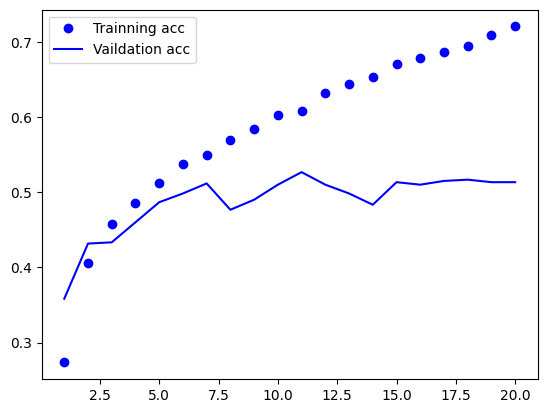

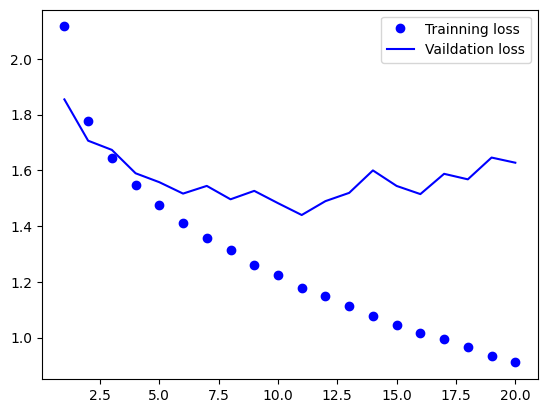

In [61]:
loss_acc_curve(history14)
model14.evaluate(sj_test_2,sj_test_label_2) #其实该函数第一个返回值是损失（loss)，第二个返回值是准确率(acc)

 ### 我们在前面提到并不是epoch越大模型越好，那么什么时候模型最好呢？使用dropout+earlystopping,获取最佳模型
 ### 为了运行速度，我采用第一个版本的缩小数据集

In [62]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=8)

In [63]:
model15 = Sequential()
model15.add(Conv2D(8, kernel_size=(3,3),activation='relu',kernel_regularizer = tf.keras.regularizers.L1(),padding='same', input_shape=input_shape))
model15.add(MaxPooling2D(pool_size=(2,2), strides=2))
#model15.add(Dropout(0.2))
model15.add(Conv2D(16,kernel_size=(3,3),activation='relu',padding='same'))
model15.add(MaxPooling2D(pool_size=(2,2), strides=2))
model13.add(Dropout(0.2))
model15.add(Flatten())
model15.add(Dense(units=10,activation='softmax'))
model15.summary()
#优化器改为ADAM
model15.compile(loss = 'categorical_crossentropy', optimizer = optimizers.Adam(),metrics = ['accuracy'])
history15 = model15.fit(sj_train,sj_train_label,callbacks=[early_stop],validation_data=(sj_val,sj_val_label),batch_size=4,epochs=350,verbose=1)

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_30 (Conv2D)                   │ (None, 32, 32, 8)           │             224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_30 (MaxPooling2D)      │ (None, 16, 16, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_31 (Conv2D)                   │ (None, 16, 16, 16)          │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_31 (MaxPooling2D)      │ (None, 8, 8, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_15 (Flatten)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 10)                  │          10,250 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,642 (45.48 KB)

 Trainable params: 11,642 (45.48 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/350
600/600 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.1700 - loss: 2.4059 - val_accuracy: 0.3700 - val_loss: 1.9627
Epoch 2/350
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3678 - loss: 1.8651 - val_accuracy: 0.3500 - val_loss: 1.8648
Epoch 3/350
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4428 - loss: 1.7196 - val_accuracy: 0.3967 - val_loss: 1.7610
Epoch 4/350
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4684 - loss: 1.5987 - val_accuracy: 0.3867 - val_loss: 1.7569
Epoch 5/350
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5193 - loss: 1.5004 - val_accuracy: 0.4200 - val_loss: 1.7598
Epoch 6/350
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5497 - loss: 1.4398 - val_accuracy: 0.4167 - val_loss: 1.7568
Epoch 7/350
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5708 - loss: 1.3709 - val_accuracy: 0.4367 - val_loss: 1.7138
Epoch 8/350
600/600 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5993 - loss: 1.3177 - val_accu

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.4356 - loss: 2.2272


[2.1819748878479004, 0.44333332777023315]

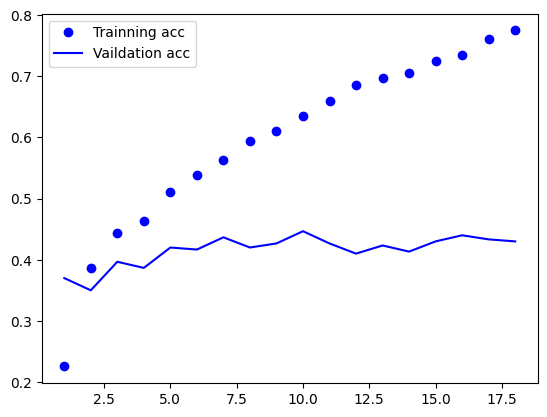

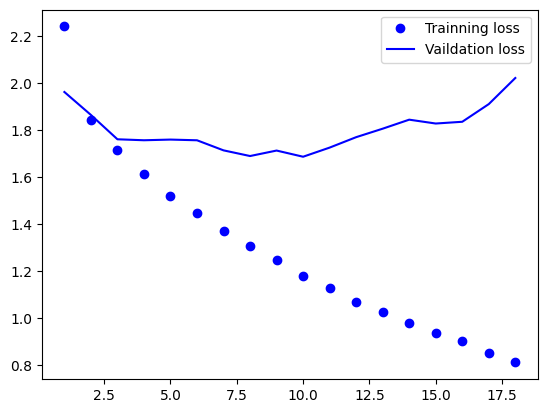

In [64]:
loss_acc_curve(history15)
model15.evaluate(sj_test,sj_test_label) #其实该函数第一个返回值是损失（loss)，第二个返回值是准确率(acc)

### 总结：模型选择epoch合适的时候，较少数据集就可以达到较大数据集刚才测试的效果，当然较大数据集也可以通过选择最佳模型进一步提高准确率

### 全数据集参与训练，测试模型性能。

In [65]:
(sj_train_3,sj_train_label_3,sj_val_3,sj_val_label_3,sj_test_3,sj_test_label_3) = train_val_test(x_images_images,y_onehot,0.16)

In [66]:
print(sj_train_3.shape,sj_val_3.shape,sj_test_3.shape)
print(sj_train_label_3.shape,sj_val_label_3.shape,sj_test_label_3.shape)

(40800, 32, 32, 3) (9600, 32, 32, 3) (9600, 32, 32, 3)
(40800, 10) (9600, 10) (9600, 10)


In [67]:
sj_train_label_3[3]

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])

In [68]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=15)

In [69]:
#全部数据集参与训练
model16 = Sequential()
model16.add(Conv2D(32, kernel_size=(3,3),activation='relu', input_shape=input_shape))
model16.add(MaxPooling2D(pool_size=(2,2), strides=2))
model16.add(Conv2D(64,kernel_size=(3,3),activation='relu'))
model16.add(MaxPooling2D(pool_size=(2,2), strides=2))
model16.add(Conv2D(64,kernel_size=(3,3),activation='relu'))

model16.add(Flatten())
model16.add(Dense(units=64, activation='relu'))
model16.add(Dense(units=10, activation='softmax'))
model16.summary()
#优化器改为ADAM
model16.compile(loss = 'categorical_crossentropy', optimizer = optimizers.Adam(0.001),metrics = ['accuracy'])
history16 = model16.fit(sj_train_3,sj_train_label_3,callbacks=[early_stop],validation_data=(sj_val_3,sj_val_label_3),batch_size=4,epochs=150,verbose=2)

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_32 (Conv2D)                   │ (None, 30, 30, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_32 (MaxPooling2D)      │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_33 (Conv2D)                   │ (None, 13, 13, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_33 (MaxPooling2D)      │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_34 (Conv2D)                   │ (None, 4, 4, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_16 (Flatten)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 64)                  │          65,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 122,570 (478.79 KB)

 Trainable params: 122,570 (478.79 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150
10200/10200 - 40s - 4ms/step - accuracy: 0.4494 - loss: 1.5021 - val_accuracy: 0.5483 - val_loss: 1.2652
Epoch 2/150
10200/10200 - 36s - 4ms/step - accuracy: 0.5863 - loss: 1.1619 - val_accuracy: 0.6051 - val_loss: 1.1204
Epoch 3/150
10200/10200 - 36s - 4ms/step - accuracy: 0.6416 - loss: 1.0179 - val_accuracy: 0.6171 - val_loss: 1.1056
Epoch 4/150
10200/10200 - 36s - 4ms/step - accuracy: 0.6733 - loss: 0.9312 - val_accuracy: 0.6329 - val_loss: 1.0899
Epoch 5/150
10200/10200 - 31s - 3ms/step - accuracy: 0.6987 - loss: 0.8619 - val_accuracy: 0.6556 - val_loss: 1.0207
Epoch 6/150
10200/10200 - 31s - 3ms/step - accuracy: 0.7147 - loss: 0.8131 - val_accuracy: 0.6530 - val_loss: 1.0506
Epoch 7/150
10200/10200 - 41s - 4ms/step - accuracy: 0.7326 - loss: 0.7584 - val_accuracy: 0.6484 - val_loss: 1.0675
Epoch 8/150
10200/10200 - 41s - 4ms/step - accuracy: 0.7481 - loss: 0.7138 - val_accuracy: 0.6515 - val_loss: 1.1153
Epoch 9/150
10200/10200 - 31s - 3ms/step - accuracy: 0.7642 - lo

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6598 - loss: 1.5202


[1.5450221300125122, 0.6555208563804626]

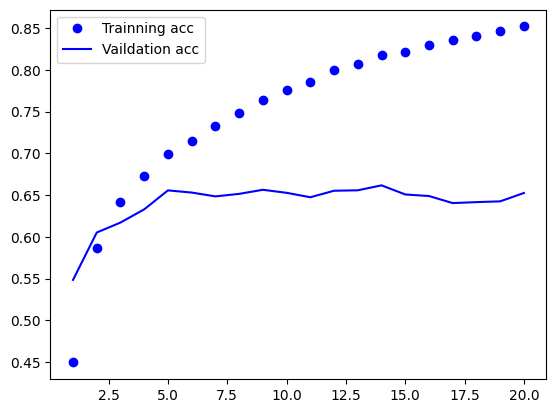

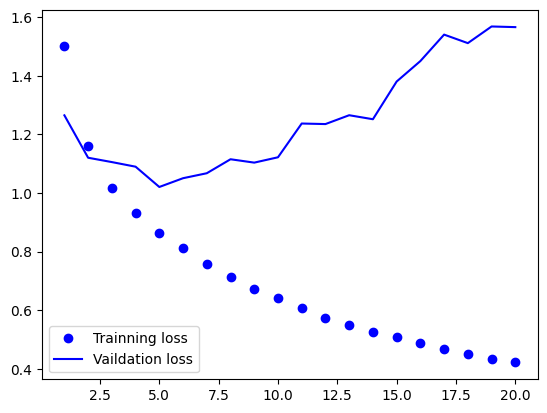

In [70]:
loss_acc_curve(history16)
model16.evaluate(sj_test_3,sj_test_label_3) #其实该函数第一个返回值是损失（loss)，第二个返回值是准确率(acc)

In [71]:
early_stop1 = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=20)

In [72]:
#在上一个版本上面增加dropout
model17 = Sequential()
model17.add(Conv2D(32, kernel_size=(3,3),activation='relu', input_shape=input_shape))
model17.add(MaxPooling2D(pool_size=(2,2), strides=2))
model17.add(Conv2D(64,kernel_size=(3,3),activation='relu'))
model17.add(MaxPooling2D(pool_size=(2,2), strides=2))
model17.add(Dropout(0.25))
model17.add(Conv2D(64,kernel_size=(3,3),activation='relu'))
model17.add(Dropout(0.2))
model17.add(Flatten())
model17.add(Dense(units=64, activation='relu'))
model17.add(Dense(units=10, activation='softmax'))
model17.summary()
#优化器改为ADAM
model17.compile(loss = 'categorical_crossentropy', optimizer = optimizers.Adam(0.001),metrics = ['accuracy'])
history17 = model17.fit(sj_train_3,sj_train_label_3,callbacks=[early_stop1],validation_data=(sj_val_3,sj_val_label_3),batch_size=4,epochs=150,verbose=2)

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_35 (Conv2D)                   │ (None, 30, 30, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_34 (MaxPooling2D)      │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_36 (Conv2D)                   │ (None, 13, 13, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_35 (MaxPooling2D)      │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_37 (Conv2D)                   │ (None, 4, 4, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_17 (Flatten)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 64)                  │          65,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 122,570 (478.79 KB)

 Trainable params: 122,570 (478.79 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150
10200/10200 - 36s - 4ms/step - accuracy: 0.4082 - loss: 1.6072 - val_accuracy: 0.5255 - val_loss: 1.3175
Epoch 2/150
10200/10200 - 43s - 4ms/step - accuracy: 0.5404 - loss: 1.2812 - val_accuracy: 0.5715 - val_loss: 1.1949
Epoch 3/150
10200/10200 - 41s - 4ms/step - accuracy: 0.5874 - loss: 1.1662 - val_accuracy: 0.5973 - val_loss: 1.1405
Epoch 4/150
10200/10200 - 35s - 3ms/step - accuracy: 0.6147 - loss: 1.0951 - val_accuracy: 0.6275 - val_loss: 1.0600
Epoch 5/150
10200/10200 - 32s - 3ms/step - accuracy: 0.6289 - loss: 1.0488 - val_accuracy: 0.6326 - val_loss: 1.0527
Epoch 6/150
10200/10200 - 32s - 3ms/step - accuracy: 0.6428 - loss: 1.0146 - val_accuracy: 0.6544 - val_loss: 0.9914
Epoch 7/150
10200/10200 - 37s - 4ms/step - accuracy: 0.6526 - loss: 0.9870 - val_accuracy: 0.6628 - val_loss: 0.9643
Epoch 8/150
10200/10200 - 41s - 4ms/step - accuracy: 0.6574 - loss: 0.9732 - val_accuracy: 0.6562 - val_loss: 0.9773
Epoch 9/150
10200/10200 - 36s - 4ms/step - accuracy: 0.6674 - lo

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6976 - loss: 0.9146


[0.9403092265129089, 0.6946874856948853]

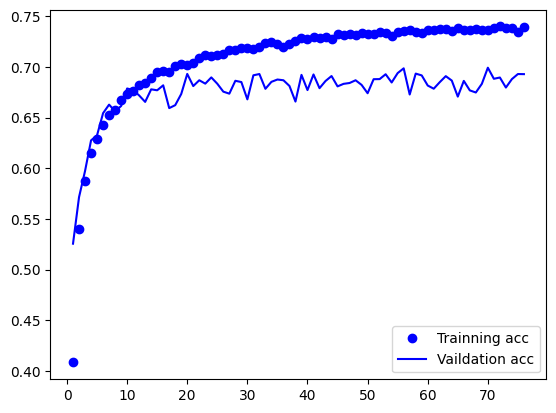

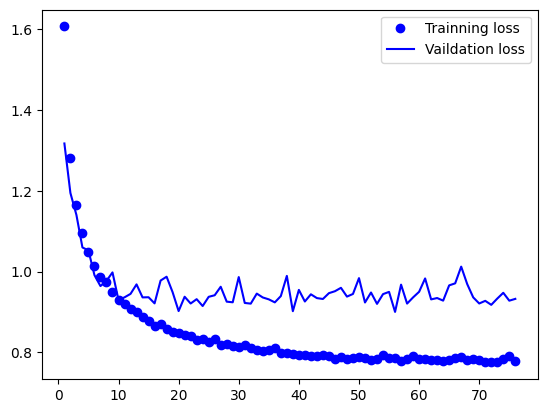

In [73]:
loss_acc_curve(history17)
model17.evaluate(sj_test_3,sj_test_label_3) #其实该函数第一个返回值是损失（loss)，第二个返回值是准确率(acc)

### 到此结束，你或许需要再仔细整理下思路。然后去完成作业吧